## 1. Загрузка всех необходимых библиотек и задача функций

In [34]:
library(RYandexTranslate)
library(devtools)
library(quantmod)
library(xts)
library(readxl)
library(anytime)
library(h2o)
library(tsfeatures)
library(tseries)
library(openxlsx) # подгружаем необходимые библиотеки 

Warning message:
"package 'tsfeatures' was built under R version 3.6.3"
Warning message:
"package 'tseries' was built under R version 3.6.3"


In [6]:
to_xts <- function(df, ...){ # для перевода фрейма во временной ряд 
    df <- as.data.frame(df)  
    #df$date = as.Date(df$date)
    ts = xts(df[,-1], order.by = df[,1])
    return(ts) 
}

In [7]:
range01 <- function(x){ # Функция для ранжирования от 0 до 1
    (x-min(x))/(max(x)-min(x))
}

In [8]:
api_key = 'trnsl.1.1.20200419T185648Z.9c7b3b3c834e4159.eb7cf2df66a7d1aa40babff1b8896068637859e5' # Yandex API ключ

In [9]:
translate = function (api_key, text = "", lang = "") # функция для языкового перевода с помощью API
{
  url = "https://translate.yandex.net/api/v1.5/tr.json/translate?"
  url = paste(url, "key=", api_key, sep = "")
  if (text != "") {
    url = paste(url, "&text=", text, sep = "")
  }
  if (lang != "") {
    url = paste(url, "&lang=", lang, sep = "")
  }
  url = gsub(pattern = " ", replacement = "%20", x = url)
  d = RCurl::getURL(url, ssl.verifyhost = 0L, ssl.verifypeer = 0L)
  d = jsonlite::fromJSON(d)
  d$code = NULL
  d
}  

In [21]:
score.sentiment <- function(sentences, pos.words, neg.words, .progress='none') # функция для подсчета сентимента
 {
 require(plyr) 
 require(stringr)
 scores <- laply(sentences, function(sentence, pos.words, neg.words){
 sentence <- gsub('[[:punct:]]', "", sentence)
 sentence <- gsub('[[:cntrl:]]', "", sentence)
 sentence <- gsub('\\d+', "", sentence)
 sentence <- tolower(sentence)
 word.list <- str_split(sentence, '\\s+')
 words <- unlist(word.list)
 pos.matches <- match(words, pos.words)
 neg.matches <- match(words, neg.words)
 pos.matches <- !is.na(pos.matches)
 neg.matches <- !is.na(neg.matches)
 score <- sum(pos.matches) - sum(neg.matches)
 return(score)
 }, pos.words, neg.words, .progress=.progress)
 scores.df <- data.frame(score=scores, text=sentences)
 return(scores.df)
 }

In [164]:
accuracy <- function(real, pred) { # функция для подсчета точности угадывания направления цены акции (лог-доходности)
    rp <- cbind(real, pred)
    rp <- as.data.frame(rp)
    rp <- exp(rp)
    rp$V3 <- as.numeric( (rp[,1] > 1) == (rp[,2] > 1) )
    return(sum(rp$V3)/nrow(rp))
}

In [417]:
accuracy_abs <- function(train, test, pred){ # функция для подсчета точности угадывания направление цены акции (абс. значения)
    pr <- NULL
    pr <- as.data.frame(pr)
    pr[1,1] <- as.numeric(as.data.frame(train$y[nrow(train)]))
    pr[1,2] <- as.numeric(as.data.frame(train$y[nrow(train)]))
    colnames(pr) <- c('r', 'p')
    ok <- cbind(as.data.frame(test$y), as.data.frame(pred$predict))
    colnames(ok) <- c('r', 'p')
    pr <- rbind(pr, ok)
    pr <- as.ts(pr)
    pr <- diff(pr, lag = 1)
    pr <- as.data.frame(pr)
    pr[,3] <- as.numeric( (pr[,1] > 0) == (pr[,2] > 0) )
    return(sum(pr[,3])/nrow(pr))
}

## 2. Подгрузка и подготовка данных

In [10]:
broendby <- read_excel('C:/Users/Митя/Brondby1_2017_2019_text.xlsx') # выкаченные твиты с помощью модуля twitterscraper в Python

In [11]:
add <- read_excel('C:/Users/Митя/add_to_br.xlsx')

In [12]:
broendby <- rbind(broendby, add)

In [13]:
head(broendby) # массив данных

timestamp,text,likes,retweets,replies
<dttm>,<chr>,<dbl>,<dbl>,<dbl>
2017-01-01,Voici les premiers rendez-vous de 2017 16 fevrier : Ludogorets - FC Kobenhavn 19 fevrier : FC Kobenhavn - Brondby,0,1,0
2017-01-01,Losningen er sensor bleer. Det arbejde vi nu med pa Nygard Plejecenter i Brondby. Souper opfindelse.#dkpleje #KL #dkpol,0,0,0
2017-01-01,"Swoja droga Paulus od dzisiaj jest zawodnikiem Broendby. Mam nadzieje, ze Rutkowscy nie beda zbyt dlugo odpoczywac po sylwestrze",2,0,0
2017-01-01,"God gratis l<U+00E6>sning: Kapitel 23 i Henrik Madsens ""Kjeld – Borgmesteren, der skabte Brondby"". @HenrikGyrupM #dkkompol http://kommunen.dk/kjeld-den-evige-borgmester/ …",0,0,0
2017-01-01,"du burde som koordinater stotte op og arrangere boycot mod fakta, det ikke i orden at vi Brondby drenge ikke kan kobe pa 2. Dagen",0,0,0
2017-01-01,"Social- og sundhedsassistenter, Brondby Kommune, Kobenhavn - http://denmark.jobrat.net/2017/01/01/social-og-sundhedsassistenter-brondby-kommune-kobenhavn/ …",0,0,0


In [14]:
broendby <- broendby[order(broendby$timestamp),] # Сортируем по дате

In [15]:
tweets <- as.data.frame(broendby)

In [16]:
colnames(tweets) <- c('Date', 'Text', 'Likes', 'Retweets', 'Replies') # дает удобные названия переменным

In [17]:
nrow(tweets)

[1] 180345

In [18]:
tweets <- tweets[!duplicated(tweets$Text), ] # удаляем дубликаты 

In [19]:
nrow(tweets) # оставили неповторяющиеся твитов

[1] 143700

## 3. Сентимент-анализ постов в Twitter

In [20]:
tweets1 <- tweets # на всякий случай

In [22]:
pos <- scan('C:/Users/Митя/Desktop/positive.txt', what='character', comment.char=';') # набор положительных слов
neg <- scan('C:/Users/Митя/Desktop/negative.txt', what='character', comment.char=';') # набор негативных слов

In [23]:
pos_da <- NULL
for (i in 1:nrow(as.data.frame(pos))) { # цикл для построчного перевода позитивных слов на датский 
   text = pos[i]
    try(
    data <- translate(api_key, text = text, lang="da"))
    if (is.null(data$text) != 1) {
    pos_da[i] <- data$text
        }
}

function (x, file = "data", ncolumns = if (is.character(x)) 1 else 5, 
    append = FALSE, sep = " ") 
cat(x, file = file, sep = c(rep.int(sep, ncolumns - 1), "\n"), 
    append = append)
<bytecode: 0x00000000614f3528>
<environment: namespace:base>

In [25]:
write.table(pos_da, 'pos_da.txt', sep = ';')

In [26]:
neg_da <- NULL 
for (i in 1:nrow(as.data.frame(neg))) { # цикл для построчного перевода негативных слов на датский 
   text = neg[i]
    try(
    data <- translate(api_key, text = text, lang="da"))
    if (is.null(data$text) != 1) {
    neg_da[i] <- data$text
        }
}

In [27]:
write.table(neg_da, 'neg_da.txt', sep = ';')

In [28]:
pos.words <- c(pos, pos_da) # твиты могут быть написаны только на двух языках: английский и датский
neg.words <- c(neg, neg_da) # будем смотреть, есть ли слова из твита с списке с позитивными словами на двух языках

In [29]:
nrow(as.data.frame(pos.words))
nrow(as.data.frame(neg.words))

[1] 4012

[1] 9566

In [30]:
pos.words <- pos.words[!duplicated(pos.words)] # удаляем повторяющиеся слова
neg.words <- neg.words[!duplicated(neg.words)] # из-за сложности перевода, переводчик иногда повторяет запрос

In [31]:
nrow(as.data.frame(pos.words)) #столько слов осталось
nrow(as.data.frame(neg.words))

[1] 3316

[1] 7570

In [32]:
tweets$Text <- as.factor(tweets$Text) # преобразовываем столбец твитов в факторную переменную

In [33]:
scores <- score.sentiment(tweets1$Text, pos.words, neg.words, .progress='text')

Loading required package: plyr

Warning message:
"package 'plyr' was built under R version 3.6.3"
Loading required package: stringr



  |======================================================================| 100%


In [35]:
scores$pos <- integer(length = nrow(scores))
scores$neut <- integer(length = nrow(scores))
scores$neg <- integer(length = nrow(scores))
for (i in 1:nrow(scores)) {
    if (scores$score[i] > 0) { # создаем для каждого типо твитов отдельные бинарные переменные 
    scores$pos[i] <- 1
} else if (scores$score[i] == 0){
    scores$neut[i] <- 1
} else if (scores$score[i] < 0){
    scores$neg[i] <- 1
}
    }

In [36]:
head(scores)

,score,text,pos,neut,neg
,<int>,<fct>,<dbl>,<dbl>,<dbl>
1,0,Voici les premiers rendez-vous de 2017 16 fevrier : Ludogorets - FC Kobenhavn 19 fevrier : FC Kobenhavn - Brondby,0,1,0
2,1,Losningen er sensor bleer. Det arbejde vi nu med pa Nygard Plejecenter i Brondby. Souper opfindelse.#dkpleje #KL #dkpol,1,0,0
3,0,"Swoja droga Paulus od dzisiaj jest zawodnikiem Broendby. Mam nadzieje, ze Rutkowscy nie beda zbyt dlugo odpoczywac po sylwestrze",0,1,0
4,2,"God gratis l<U+00E6>sning: Kapitel 23 i Henrik Madsens ""Kjeld – Borgmesteren, der skabte Brondby"". @HenrikGyrupM #dkkompol http://kommunen.dk/kjeld-den-evige-borgmester/ …",1,0,0
5,1,"du burde som koordinater stotte op og arrangere boycot mod fakta, det ikke i orden at vi Brondby drenge ikke kan kobe pa 2. Dagen",1,0,0
6,0,"Social- og sundhedsassistenter, Brondby Kommune, Kobenhavn - http://denmark.jobrat.net/2017/01/01/social-og-sundhedsassistenter-brondby-kommune-kobenhavn/ …",0,1,0


## 4. Подсчет основных метрик

In [37]:
metrics <- cbind(as.character(tweets1$Date), scores$score, scores$pos, scores$neut, scores$neg)

In [38]:
metrics <- as.data.frame(metrics)

In [39]:
colnames(metrics) <- c('Date', 'Score', 'Positive', 'Neutral', 'Negative')

In [40]:
metrics$Date <- as.Date(metrics$Date)
for (i in 2:ncol(metrics)){
    metrics[,i] <- as.numeric(as.character(metrics[,i]))
}

In [42]:
head(metrics)

,Date,Score,Positive,Neutral,Negative
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,2017-01-01,0,0,1,0
2,2017-01-01,1,1,0,0
3,2017-01-01,0,0,1,0
4,2017-01-01,2,1,0,0
5,2017-01-01,1,1,0,0
6,2017-01-01,0,0,1,0


In [43]:
metrics <- aggregate(cbind(Score, Positive, Neutral, Negative) ~ Date, metrics, sum) # считаем метрику на день

In [44]:
metrics <- to_xts(metrics) # делаем из фрейма временной ряд

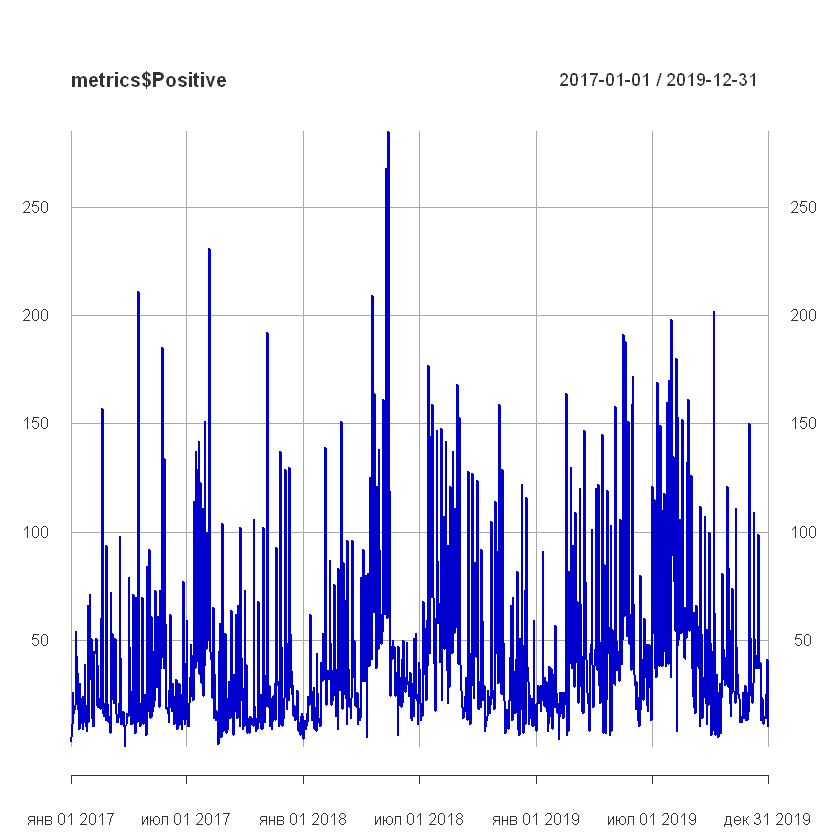

In [47]:
plot(metrics$Positive, col = 'blue3')

In [48]:
getSymbols('BIF.CO', src = 'yahoo') # качаем серию

'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.




[1] "BIF.CO"

In [234]:
metrics$Volume <- metrics$Positive + metrics$Neutral + metrics$Negative # добавляем метрики 
metrics$Ratio <- metrics$Positive / metrics$Negative
metrics$Polarity <- (metrics$Positive - metrics$Negative) / (metrics$Positive + metrics$Negative)
metrics$Composite <- (metrics$Positive - metrics$Negative) / metrics$Volume

## 5. Подготова данных для построения моделей

In [235]:
data <- merge(BIF.CO$BIF.CO.Close['2017-01-01::2019-12-31'], metrics)

In [236]:
head(data)

           BIF.CO.Close Score Positive Neutral Negative Volume    Ratio
2017-01-01           NA     3        3       4        1      8 3.000000
2017-01-02     0.489458    -2        5      19        8     32 0.625000
2017-01-03     0.493949     8       11      18        6     35 1.833333
2017-01-04     0.493949    22       26      20       13     59 2.000000
2017-01-05     0.489458     9       16      44       12     72 1.333333
2017-01-06     0.493949     8       16      15        9     40 1.777778
             Polarity   Composite
2017-01-01  0.5000000  0.25000000
2017-01-02 -0.2307692 -0.09375000
2017-01-03  0.2941176  0.14285714
2017-01-04  0.3333333  0.22033898
2017-01-05  0.1428571  0.05555556
2017-01-06  0.2800000  0.17500000

In [237]:
cor(data[complete.cases(data),])

,BIF.CO.Close,Score,Positive,Neutral,Negative,Volume,Ratio,Polarity,Composite
BIF.CO.Close,1.00000000,0.15733898,0.28441881,0.21335669,0.26233049,0.2606153,-0.06984649,-0.02751612,-0.02829640
Score,0.15733898,1.00000000,0.50446049,0.33481100,0.06874149,0.3363252,0.45924385,0.56522204,0.57034100
Positive,0.28441881,0.50446049,1.00000000,0.83862471,0.87899023,0.9484998,-0.01516663,0.03398096,0.02999836
Neutral,0.21335669,0.33481100,0.83862471,1.00000000,0.78531704,0.9543595,-0.08906151,-0.06671370,-0.12099339
Negative,0.26233049,0.06874149,0.87899023,0.78531704,1.00000000,0.9173409,-0.31863450,-0.32211209,-0.32532931
Volume,0.26061530,0.33632525,0.94849975,0.95435945,0.91734090,1.0000000,-0.13240835,-0.10738336,-0.13619283
Ratio,-0.06984649,0.45924385,-0.01516663,-0.08906151,-0.31863450,-0.1324084,1.00000000,0.92104621,0.90334015
Polarity,-0.02751612,0.56522204,0.03398096,-0.06671370,-0.32211209,-0.1073834,0.92104621,1.00000000,0.97726970
Composite,-0.02829640,0.57034100,0.02999836,-0.12099339,-0.32532931,-0.1361928,0.90334015,0.97726970,1.00000000


In [59]:
getSymbols('^OMXC25', scr='yahoo', from = "2017-01-01", to = "2019-12-31") # Проблемы... Сделаем вручную

Warning message:
"^OMXC25 download failed; trying again."


ERROR: Error in getSymbols.yahoo(Symbols = "^OMXC25", env = <environment>, verbose = FALSE, : Unable to import "^OMXC25".
^OMXC25 download failed after two attempts. Error message:
HTTP error 404.


In [239]:
OMXC25 <- read.csv('Downloads/OMX_Copenhagen_25_Historical_Data.csv') # биржа Копенгагена
colnames(OMXC25)[1] <- 'Date'
OMXC25$Date <- anydate(OMXC25$Date)
OMXC25$Price <- as.numeric(gsub(',', '', OMXC25$Price))
OMXC25 <- to_xts(OMXC25)

In [240]:
data <- merge(data, OMXC25$Price)

In [241]:
head(data)

           BIF.CO.Close Score Positive Neutral Negative Volume    Ratio
2017-01-01           NA     3        3       4        1      8 3.000000
2017-01-02     0.489458    -2        5      19        8     32 0.625000
2017-01-03     0.493949     8       11      18        6     35 1.833333
2017-01-04     0.493949    22       26      20       13     59 2.000000
2017-01-05     0.489458     9       16      44       12     72 1.333333
2017-01-06     0.493949     8       16      15        9     40 1.777778
             Polarity   Composite   Price
2017-01-01  0.5000000  0.25000000      NA
2017-01-02 -0.2307692 -0.09375000 1034.03
2017-01-03  0.2941176  0.14285714 1030.89
2017-01-04  0.3333333  0.22033898 1025.78
2017-01-05  0.1428571  0.05555556 1034.99
2017-01-06  0.2800000  0.17500000 1037.59

In [242]:
colnames(data)[ncol(data)] <- 'OMXC'

## 6. Построение линейных моделей

### 6.1. Модель 1. Срез понедельников

In [243]:
for_lm <- as.data.frame(data)

In [244]:
for_lm$y <- dplyr::lead(for_lm$BIF.CO.Close)

In [245]:
for_lm <- for_lm[complete.cases(for_lm),]

In [246]:
for_lm <- diff(log(as.ts(range01(for_lm))))

In [247]:
nrow(for_lm)

[1] 586

In [248]:
for_lm <- as.data.frame(for_lm)

In [249]:
for_lm$Score[!is.finite(for_lm$Score)] <- 0

In [250]:
cor(for_lm)

,BIF.CO.Close,Score,Positive,Neutral,Negative,Volume,Ratio,Polarity,Composite,OMXC,y
BIF.CO.Close,1.00000000,-0.03583644,0.033791987,0.04890963,0.02957138,0.02773046,0.01513709,0.026539649,0.03177380,0.10737037,0.549883357
Score,-0.03583644,1.00000000,0.318139205,0.17968400,-0.08600992,0.16443302,0.36252213,0.466262162,0.47420557,-0.01650694,0.019681046
Positive,0.03379199,0.31813920,1.000000000,0.86050831,0.83565244,0.94647893,0.10081627,0.144347944,0.14122815,0.04310000,0.004129623
Neutral,0.04890963,0.17968400,0.860508307,1.00000000,0.80589118,0.94533271,-0.04583498,-0.021250232,-0.06447949,0.07913704,-0.030510087
Negative,0.02957138,-0.08600992,0.835652438,0.80589118,1.00000000,0.91133545,-0.30080627,-0.315375626,-0.31977082,0.06032023,-0.010528264
Volume,0.02773046,0.16443302,0.946478925,0.94533271,0.91133545,1.00000000,-0.08752543,-0.062965832,-0.08557270,0.05533492,-0.012278404
Ratio,0.01513709,0.36252213,0.100816267,-0.04583498,-0.30080627,-0.08752543,1.00000000,0.915126964,0.90937934,-0.01144107,0.018160654
Polarity,0.02653965,0.46626216,0.144347944,-0.02125023,-0.31537563,-0.06296583,0.91512696,1.000000000,0.97588125,-0.02328110,0.008589479
Composite,0.03177380,0.47420557,0.141228152,-0.06447949,-0.31977082,-0.08557270,0.90937934,0.975881255,1.00000000,-0.03442363,0.014933124
OMXC,0.10737037,-0.01650694,0.043100004,0.07913704,0.06032023,0.05533492,-0.01144107,-0.023281100,-0.03442363,1.00000000,0.099922446


In [251]:
m1 <- lm(y~ BIF.CO.Close + Neutral + OMXC + Score + Composite, data = for_lm)

In [252]:
summary(m1)


Call:
lm(formula = y ~ BIF.CO.Close + Neutral + OMXC + Score + Composite, 
    data = for_lm)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.456e-03 -7.458e-05 -3.700e-07  7.280e-05  1.611e-03 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -5.749e-07  9.743e-06  -0.059   0.9530    
BIF.CO.Close  5.779e-01  3.638e-02  15.883   <2e-16 ***
Neutral      -9.293e-05  4.309e-05  -2.156   0.0315 *  
OMXC          1.612e-03  1.206e-03   1.337   0.1816    
Score         6.962e-05  3.830e-05   1.818   0.0696 .  
Composite    -1.161e-02  1.133e-02  -1.025   0.3057    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0002357 on 580 degrees of freedom
Multiple R-squared:  0.3117,	Adjusted R-squared:  0.3058 
F-statistic: 52.53 on 5 and 580 DF,  p-value: < 2.2e-16


In [253]:
nrow(for_lm) * 0.9
nrow(for_lm)

[1] 527.4

[1] 586

In [254]:
lm_train <- for_lm[1:528,]
lm_test <- for_lm[529:586,]

In [255]:
m1 <- lm(y~ BIF.CO.Close + Neutral + OMXC + Score + Composite, data = lm_train)

In [256]:
summary(m1)


Call:
lm(formula = y ~ BIF.CO.Close + Neutral + OMXC + Score + Composite, 
    data = lm_train)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.462e-03 -7.538e-05  2.600e-07  7.148e-05  1.609e-03 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.970e-07  1.073e-05   0.046   0.9631    
BIF.CO.Close  5.815e-01  3.830e-02  15.181   <2e-16 ***
Neutral      -9.797e-05  4.560e-05  -2.149   0.0321 *  
OMXC          1.795e-03  1.338e-03   1.341   0.1804    
Score         7.041e-05  4.043e-05   1.741   0.0822 .  
Composite    -1.097e-02  1.243e-02  -0.882   0.3780    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0002465 on 522 degrees of freedom
Multiple R-squared:  0.3167,	Adjusted R-squared:  0.3101 
F-statistic: 48.39 on 5 and 522 DF,  p-value: < 2.2e-16


In [257]:
lm_pred <- predict(m1, lm_test)

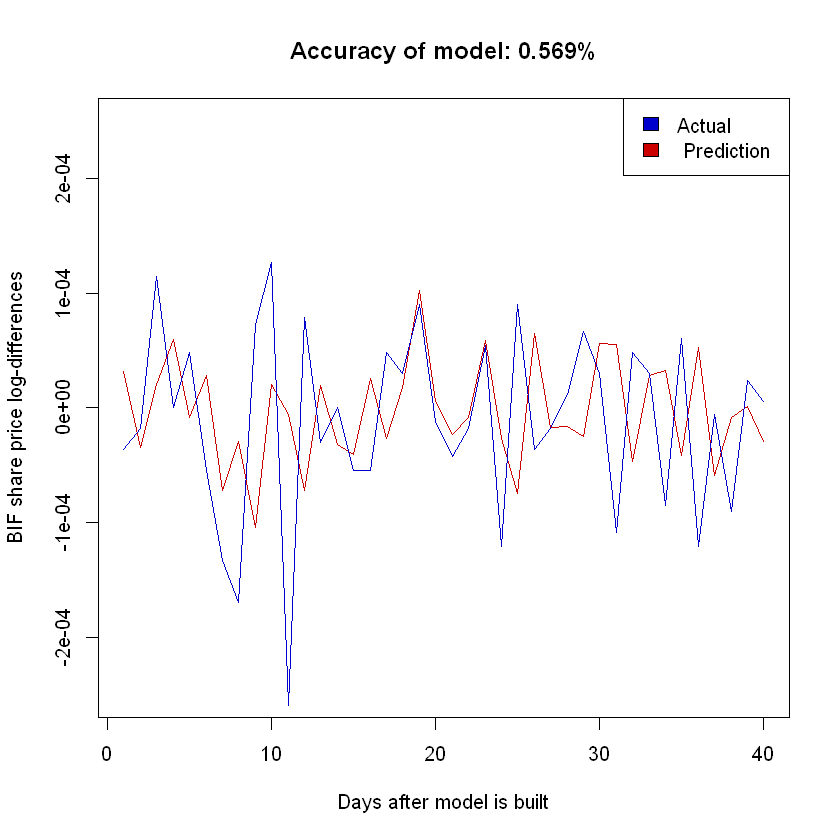

In [258]:
plot(lm_pred[1:40], t = 'l', col = 'red3', ylab = 'BIF share price log-differences', 
     xlab = 'Days after model is built', ylim = c(-0.00025,0.00025), 
     main = paste0('Accuracy of model: ', round(accuracy(lm_test$y, lm_pred), digits = 3), '%'))
lines(lm_test$y[1:40], col = 'blue3')
legend(legend = c('Actual', ' Prediction'), fill = c('blue3', 'red3'), 'topright')

### 6.2. Модель 2. Лог-доходности метрик за предыдущий торговый день

In [259]:
for_lm1 <- as.data.frame(data)
for_lm1$BIF.CO.Close <- dplyr::lead(for_lm1$BIF.CO.Close)
for_lm1$OMXC <- dplyr::lead(for_lm1$OMXC)
for_lm1 <- for_lm1[complete.cases(for_lm1),]
colnames(for_lm1)[1] <- 'y'
for_lm1$BIF.CO.Close <- dplyr::lag(for_lm1$y)
for_lm1$OMXC <- dplyr::lag(for_lm1$OMXC)
for_lm1 <- for_lm1[-1,]
for_lm1 <- diff(log(as.ts(range01(for_lm1))))
for_lm1 <- as.data.frame(for_lm1)
for_lm1$Score[!is.finite(for_lm1$Score)] <- 0

In [260]:
cor(for_lm1)

,y,Score,Positive,Neutral,Negative,Volume,Ratio,Polarity,Composite,OMXC,BIF.CO.Close
y,1.00000000,0.027814709,-0.022702731,-0.03855233,-0.032360803,-0.02996341,0.021599459,0.0128087130,0.01708618,0.051790562,-0.0278279391
Score,0.02781471,1.000000000,0.345884819,0.20865552,0.001363129,0.20335333,0.333721717,0.4677958796,0.47494574,-0.037484514,-0.0401475716
Positive,-0.02270273,0.345884819,1.000000000,0.90893954,0.891987726,0.96212974,-0.001884244,0.0512920869,0.04220910,0.023681731,0.0089662391
Neutral,-0.03855233,0.208655517,0.908939538,1.00000000,0.872144389,0.96689657,-0.112037053,-0.0850260270,-0.12612970,0.045694530,0.0290908138
Negative,-0.03236080,0.001363129,0.891987726,0.87214439,1.000000000,0.93915943,-0.294820339,-0.3076893601,-0.31577719,0.047810291,0.0157372510
Volume,-0.02996341,0.203353333,0.962129742,0.96689657,0.939159433,1.00000000,-0.148455079,-0.1198132991,-0.14438915,0.031138479,0.0167611971
Ratio,0.02159946,0.333721717,-0.001884244,-0.11203705,-0.294820339,-0.14845508,1.000000000,0.9135459572,0.89301177,0.006495286,-0.0105084970
Polarity,0.01280871,0.467795880,0.051292087,-0.08502603,-0.307689360,-0.11981330,0.913545957,1.0000000000,0.97664088,-0.014780643,0.0002432753
Composite,0.01708618,0.474945736,0.042209103,-0.12612970,-0.315777193,-0.14438915,0.893011768,0.9766408789,1.00000000,-0.031924129,-0.0013758598
OMXC,0.05179056,-0.037484514,0.023681731,0.04569453,0.047810291,0.03113848,0.006495286,-0.0147806426,-0.03192413,1.000000000,0.1147375709


In [261]:
m2 <- lm(y ~ BIF.CO.Close + Neutral + OMXC + Score + Ratio, data = for_lm1)

In [262]:
summary(m2) # вообще незначимая модель


Call:
lm(formula = y ~ BIF.CO.Close + Neutral + OMXC + Score + Ratio, 
    data = for_lm1)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0043019 -0.0000610 -0.0000001  0.0000569  0.0017016 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)
(Intercept)  -5.918e-07  9.375e-06  -0.063    0.950
BIF.CO.Close -3.166e-02  3.695e-02  -0.857    0.392
Neutral      -4.273e-05  3.420e-05  -1.249    0.212
OMXC          2.114e-03  1.325e-03   1.595    0.111
Score         3.228e-05  3.453e-05   0.935    0.350
Ratio         1.124e-04  1.531e-03   0.073    0.942

Residual standard error: 0.0002557 on 739 degrees of freedom
Multiple R-squared:  0.006897,	Adjusted R-squared:  0.0001774 
F-statistic: 1.026 on 5 and 739 DF,  p-value: 0.4009


### 6.3. Модель 3. Лог-доходности метрик за прыдущий день

In [325]:
for_lm3 <- merge(diff(log(data$BIF.CO.Close[complete.cases(data$BIF.CO.Close),])),
                diff(log(range01(data[,-c(1,10)]))), all = FALSE,
                diff(log(data$OMXC[complete.cases(data$OMXC),])))

In [326]:
for_lm3 <- for_lm3[-1,]
for_lm3 <- as.data.frame(for_lm3)
for_lm3$Score[!is.finite(for_lm3$Score)] <- 0

In [328]:
for_lm3$y <- dplyr::lead(for_lm3$BIF.CO.Close)
for_lm3 <- for_lm3[-nrow(for_lm3),]

In [329]:
cor(for_lm3)

,BIF.CO.Close,Score,Positive,Neutral,Negative,Volume,Ratio,Polarity,Composite,OMXC,y
BIF.CO.Close,1.000000000,-0.06663490,0.02752573,0.05957536,0.04358594,0.04418585,-0.01204770,0.0087903739,0.004390568,0.1210903627,0.01654080
Score,-0.066634897,1.00000000,0.33317272,0.17950126,-0.04514195,0.17559024,0.36078903,0.4812522747,0.487655984,-0.0408834359,0.03399950
Positive,0.027525725,0.33317272,1.00000000,0.87614115,0.86391295,0.95006085,0.06603574,0.1176955670,0.112227441,0.0192013040,-0.01551489
Neutral,0.059575361,0.17950126,0.87614115,1.00000000,0.83450941,0.95716543,-0.06936184,-0.0453556931,-0.093118437,0.0571615486,-0.02326147
Negative,0.043585940,-0.04514195,0.86391295,0.83450941,1.00000000,0.92049689,-0.28529574,-0.2961368877,-0.299983995,0.0478629720,-0.03256625
Volume,0.044185846,0.17559024,0.95006085,0.95716543,0.92049689,1.00000000,-0.10135995,-0.0736811627,-0.100207491,0.0346188810,-0.01767847
Ratio,-0.012047703,0.36078903,0.06603574,-0.06936184,-0.28529574,-0.10135995,1.00000000,0.9212134515,0.902710128,0.0271122136,0.03425942
Polarity,0.008790374,0.48125227,0.11769557,-0.04535569,-0.29613689,-0.07368116,0.92121345,1.0000000000,0.976704569,-0.0001313394,0.02593469
Composite,0.004390568,0.48765598,0.11222744,-0.09311844,-0.29998399,-0.10020749,0.90271013,0.9767045694,1.000000000,-0.0198423872,0.02745493
OMXC,0.121090363,-0.04088344,0.01920130,0.05716155,0.04786297,0.03461888,0.02711221,-0.0001313394,-0.019842387,1.0000000000,0.05879147


In [330]:
m3 <- lm(y ~ BIF.CO.Close + Neutral + OMXC + Score + Ratio, data = for_lm3)

In [331]:
summary(m3) # тоже незначимая модель


Call:
lm(formula = y ~ BIF.CO.Close + Neutral + OMXC + Score + Ratio, 
    data = for_lm3)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41197 -0.01229 -0.00032  0.01263  0.15582 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)
(Intercept)  -0.0002396  0.0011736  -0.204    0.838
BIF.CO.Close  0.0139219  0.0371128   0.375    0.708
Neutral      -0.0041041  0.0047091  -0.872    0.384
OMXC          0.2336876  0.1442806   1.620    0.106
Score         0.0041514  0.0045293   0.917    0.360
Ratio         0.0844444  0.1964367   0.430    0.667

Residual standard error: 0.03151 on 739 degrees of freedom
Multiple R-squared:  0.006377,	Adjusted R-squared:  -0.0003459 
F-statistic: 0.9485 on 5 and 739 DF,  p-value: 0.4488


### 6.4. Модель 1 с переобучением

## 7. Построение нелинейных моделей на основе tsfeatures и autoML 

In [334]:
h2o.init() # Подключениек H2O

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         58 seconds 211 milliseconds 
    H2O cluster timezone:       Europe/Moscow 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    18 days  
    H2O cluster name:           H2O_started_from_R_Р СљР С‘РЎвЂљРЎРЏ_lpr650 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.66 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.1 (2019-07-05) 



### 7.1. Модель 1. Абсолютные значения, 10 лаговых переменных

In [351]:
for_autoML <- as.data.frame(data)

In [352]:
for_autoML <- for_autoML[complete.cases(for_autoML),]

In [353]:
for (i in 3:(nrow(x = for_autoML))) { # Создание статистических метрик 
    x = 10 # Количество столбцов
    f_list <- for_autoML[c(1:i),c(1:x)]
    myfeatures <- tsfeatures(f_list)
    myfeatures  <- as.data.frame(myfeatures)
    for (k in 1:nrow(myfeatures)){
        a <- myfeatures[k,]
        colnames(a) <- paste0(colnames(a), '.', colnames(for_autoML)[k])
        col1 <- x+1+(k-1)*(ncol(a))
        col2 <-  x+1+k*(ncol(a)) - 1
        for_autoML[i, c(col1:col2)] <- a
    }
}

In [354]:
for_autoML <- for_autoML[-c(1:2),] # Удаляю первые строчки, по которым не считались метрики

In [355]:
for_autoML <- for_autoML[,colSums(is.na(for_autoML))<nrow(for_autoML)] # Удаляю все столбцы, где только NA  

In [356]:
while (sum(is.na(for_autoML)) != 0){
    for_autoML <- for_autoML[-1,]
}

In [360]:
dim(for_autoML)

[1] 737 161

In [362]:
for (l in 1:10){ # Количество лаговых переменных для создания
    for (j in 1:160){
        for_autoML[,(160*l+j)] <- dplyr::lag(for_autoML[,j], n = l)
        colnames(for_autoML)[as.numeric((160*l+j))] <- as.character(paste0(as.character(colnames(for_autoML)[(j)]), '.l', l))
    }
}

In [364]:
for_autoML <- for_autoML[-c(1:l),]

In [372]:
for_autoML$y <- dplyr::lead(for_autoML$BIF.CO.Close)

In [376]:
y <- 'y'

In [373]:
for_autoML <- for_autoML[-nrow(for_autoML),]

In [374]:
nrow(for_autoML)
nrow(for_autoML) * 0.9

[1] 726

[1] 653.4

In [375]:
train <- as.h2o(for_autoML[c(1:653),])
test <- as.h2o(for_autoML[c(654:726),])

Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."


  |======================================================================| 100%


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."


  |======================================================================| 100%


In [378]:
oldw <- getOption("warn")
options(warn = -1)
aml <- h2o.automl(y = y,
                  training_frame = train,
                # leaderboard_frame = test,
                  max_runtime_secs = 300,
                  seed = 1,
                  project_name = "aml")
options(warn = oldw)

  |                                                                      |   0%
  |======================================================================| 100%


In [379]:
aml@leaderboard

                                             model_id mean_residual_deviance
1 StackedEnsemble_BestOfFamily_AutoML_20200422_042503            0.001230940
2    StackedEnsemble_AllModels_AutoML_20200422_042503            0.001238365
3          GBM_grid__1_AutoML_20200422_042503_model_1            0.001329967
4                        DRF_1_AutoML_20200422_042503            0.001449920
5                        XRT_1_AutoML_20200422_042503            0.002094262
6                        GLM_1_AutoML_20200422_042503            0.002181229
        rmse         mse        mae      rmsle
1 0.03508475 0.001230940 0.01782584 0.01559543
2 0.03519041 0.001238365 0.01787892 0.01564256
3 0.03646871 0.001329967 0.01863217 0.01626663
4 0.03807782 0.001449920 0.01872481 0.01674028
5 0.04576311 0.002094262 0.02010733 0.02002251
6 0.04670363 0.002181229 0.02736321 0.02180600

[17 rows x 6 columns] 

In [380]:
aml@leader

Model Details:

H2ORegressionModel: stackedensemble
Model ID:  StackedEnsemble_BestOfFamily_AutoML_20200422_042503 
NULL


H2ORegressionMetrics: stackedensemble
** Reported on training data. **

MSE:  0.0002216386
RMSE:  0.01488753
MAE:  0.009943589
RMSLE:  0.007467685
Mean Residual Deviance :  0.0002216386



H2ORegressionMetrics: stackedensemble
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.00123094
RMSE:  0.03508475
MAE:  0.01782584
RMSLE:  0.01559543
Mean Residual Deviance :  0.00123094



In [381]:
pred <- h2o.predict(aml, test)

  |======================================================================| 100%


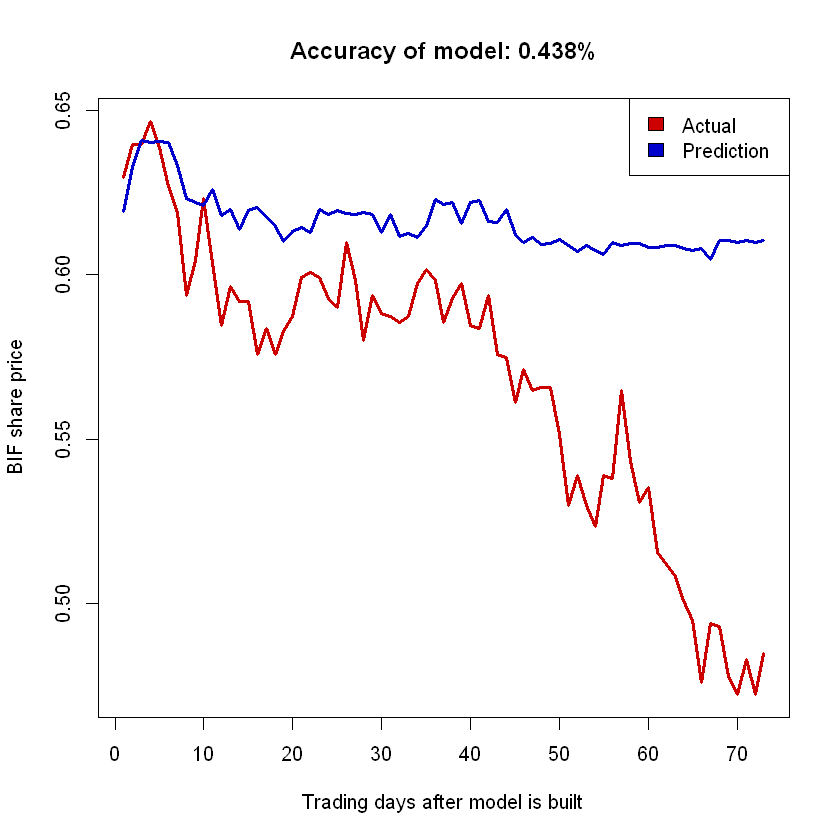

In [416]:
plot(as.ts(as.data.frame(test$y)),col = 'red3', t = 'l', xlab = 'Trading days after model is built', 
                                            ylab = 'BIF share price', lwd = 3,
    main = paste0('Accuracy of model: ', round(accuracy_abs(train, test, pred), digits = 3), '%'))
lines(as.ts(as.data.frame(pred$predict)), col = 'blue3', lwd = 3)
legend(legend = c('Actual','Prediction'), fill = c('red3', 'blue3'), 'topright')

### 7.2. Модель 1 с переобучением

In [419]:
final_pred <- NULL 
final_pred <- as.data.frame(final_pred)
final_pred[1,1] <- as.numeric(as.data.frame(for_autoML$y[i-1]))
final_pred[1,2] <- as.numeric(as.data.frame(for_autoML$y[i-1])) 
for (i in 654:726){
    train <- as.h2o(for_autoML[c(1:(i-1)),])
    test <- as.h2o(for_autoML[c(i:726),])
    oldw <- getOption("warn")
    options(warn = -1)
    aml1p <- h2o.automl(y = y,
                  training_frame = train,
                # leaderboard_frame = test,
                  max_runtime_secs = 60,
                  seed = 1,
                  project_name = paste0("aml1p",i))
    options(warn = oldw)
    pred <- h2o.predict(aml1p, test)
    final_pred[(i-652),1] <- as.numeric(as.data.frame(pred$predict[1]))
    final_pred[(i-652),2] <- as.numeric(as.data.frame(test$y[1]))
}

  |======================================================================| 100%
  |======================================================================| 100%
  |                                                                      |   0%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |                                                                      |   0%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |                                     

  |                                                                      |   0%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |                                                                      |   0%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |                                                                      |   0%
  |======================================================================| 100%
  |=====================================

ERROR: Error in .h2o.doSafeREST(h2oRestApiVersion = h2oRestApiVersion, urlSuffix = page, : 

ERROR MESSAGE:

Object 'dummy' not found in function: predict for argument: model




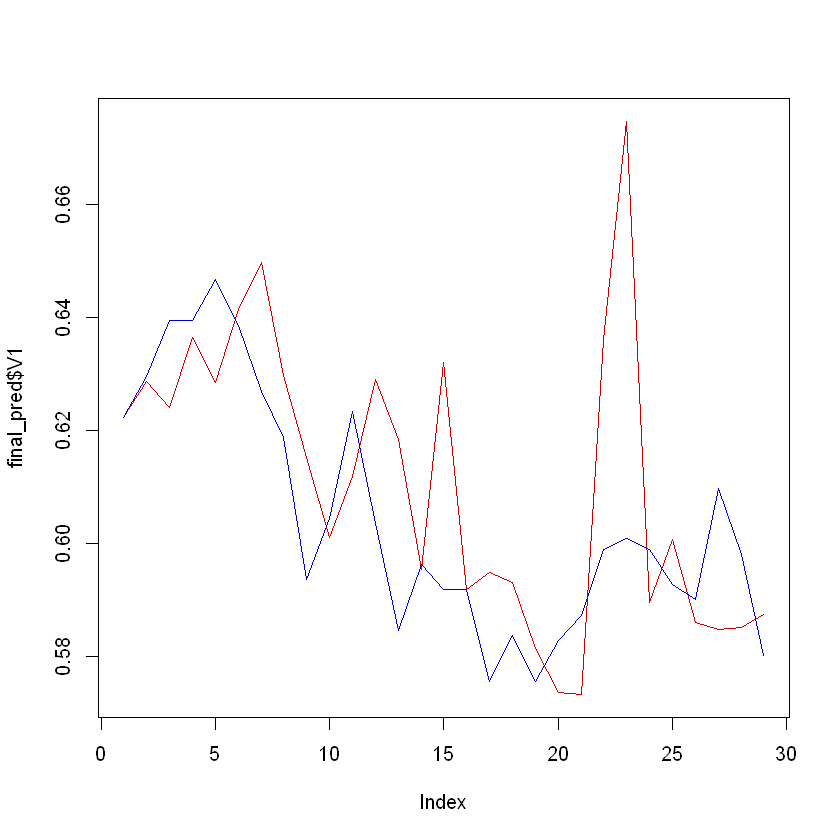

In [426]:
plot(final_pred$V1, t ='l', col = 'red3')
lines(final_pred$V2, col = 'blue3')

In [824]:
# Завтра сделать так, где игрик - доходности 

                                             model_id mean_residual_deviance
1    StackedEnsemble_AllModels_AutoML_20200421_025302            0.001035996
2 StackedEnsemble_BestOfFamily_AutoML_20200421_025302            0.001055502
3          GBM_grid__1_AutoML_20200421_025302_model_1            0.001080970
4                        GBM_3_AutoML_20200421_025302            0.001109094
5                        GBM_2_AutoML_20200421_025302            0.001118453
6          GBM_grid__1_AutoML_20200421_025302_model_2            0.001172262
        rmse         mse        mae      rmsle
1 0.03218689 0.001035996 0.01722525 0.01459783
2 0.03248849 0.001055502 0.01744447 0.01474886
3 0.03287810 0.001080970 0.01789560 0.01498107
4 0.03330307 0.001109094 0.01753292 0.01473974
5 0.03344328 0.001118453 0.01682354 0.01463893
6 0.03423831 0.001172262 0.01607081 0.01500103

[16 rows x 6 columns] 

In [904]:
for_aml.rtn <- for_plot3[complete.cases(for_plot3),]

In [905]:
for_aml.rtn <- as.data.frame(for_aml.rtn)

In [906]:
for_aml.rtn <- range01(for_aml.rtn)

In [907]:
rownames(for_aml.rtn) <- NULL 

In [908]:
for_aml.rtn <- as.ts(for_aml.rtn)

In [909]:
for_aml.rtn <- diff(log(for_aml.rtn), lag = 1)

In [910]:
for_aml.rtn <- as.data.frame(for_aml.rtn)

In [911]:
for_aml.rtn$Score[which(!is.finite(for_aml.rtn$Score))] <- 0

In [912]:
library(tseries)

In [913]:
for (c in 1:10){
    adf <- adf.test(x = for_aml.rtn[,c])
    print(adf$p.value)
}

[1] 0.01
[1] 0.01
[1] 0.01
[1] 0.01
[1] 0.01
[1] 0.01
[1] 0.01
[1] 0.01
[1] 0.01
[1] 0.01


In [914]:
for (i in 3:(nrow(x = for_aml.rtn))) {
    x = 10
    f_list <- for_aml.rtn[c(1:i),c(1:x)]
    myfeatures <- tsfeatures(f_list)
    myfeatures  <- as.data.frame(myfeatures)
    for (k in 1:nrow(myfeatures)){
        a <- myfeatures[k,]
        colnames(a) <- paste0(colnames(a), '.', colnames(for_aml.rtn)[k])
        col1 <- x+1+(k-1)*(ncol(a))
        col2 <-  x+1+k*(ncol(a)) - 1
        for_aml.rtn[i, c(col1:col2)] <- a
    }
}

In [915]:
for_aml.rtn <- for_aml.rtn[,colSums(is.na(for_aml.rtn))<nrow(for_aml.rtn)]
ncol(for_aml.rtn)

[1] 160

In [916]:
for (i in 1:10){
    for (j in 1:160){
        for_aml.rtn[,(160*i+j)] <- dplyr::lag(for_aml.rtn[,j], n = i)
        colnames(for_aml.rtn)[(160*i+j)] <- as.character(paste0(as.character(colnames(for_aml.rtn)[(j)]), '.l', i))
    }
}

In [917]:
for_aml.rtn$y <- dplyr::lead(for_aml.rtn$BIF.CO.Close, n = 1)

In [922]:
y <- 'y'

In [918]:
for_aml.rtn <- for_aml.rtn[-c(1:20, nrow(for_aml.rtn)),]

In [919]:
sum(is.na(for_aml.rtn)) 

[1] 0

In [923]:
dim(for_aml.rtn)

[1]  725 1761

In [931]:
train <- as.h2o(for_aml.rtn[c(1:600),])
test <- as.h2o(for_aml.rtn[c(601:725),])
oldw <- getOption("warn")
options(warn = -1)
aml_rtn <- h2o.automl(y = y,
                  training_frame = train,
                  max_runtime_secs = 120,
                  leaderboard_frame = test,
                  seed = 1,
                  project_name = "new_n_t.rtn")
options(warn = oldw)

  |======================================================================| 100%
  |======================================================================| 100%

ERROR: Unexpected HTTP Status code: 412 Precondition Failed (url = http://localhost:54321/99/AutoMLBuilder)

water.exceptions.H2OIllegalArgumentException
 [1] "water.exceptions.H2OIllegalArgumentException: Cannot use leaderboard new_n_t.rtn@@y with a new leaderboard frame (existing leaderboard frame: null)."
 [2] "    ai.h2o.automl.leaderboard.Leaderboard.getOrMake(Leaderboard.java:72)"                                                                            
 [3] "    ai.h2o.automl.AutoML.initLeaderboard(AutoML.java:343)"                                                                                           
 [4] "    ai.h2o.automl.AutoML.<init>(AutoML.java:209)"                                                                                                    
 [5] "    ai.h2o.automl.AutoML.startAutoML(AutoML.java:110)" 

ERROR: Error in .h2o.doSafeREST(h2oRestApiVersion = h2oRestApiVersion, urlSuffix = page, : 

ERROR MESSAGE:

Cannot use leaderboard new_n_t.rtn@@y with a new leaderboard frame (existing leaderboard frame: null).




In [925]:
pred.rtn <- h2o.predict(aml_rtn, test)

  |======================================================================| 100%


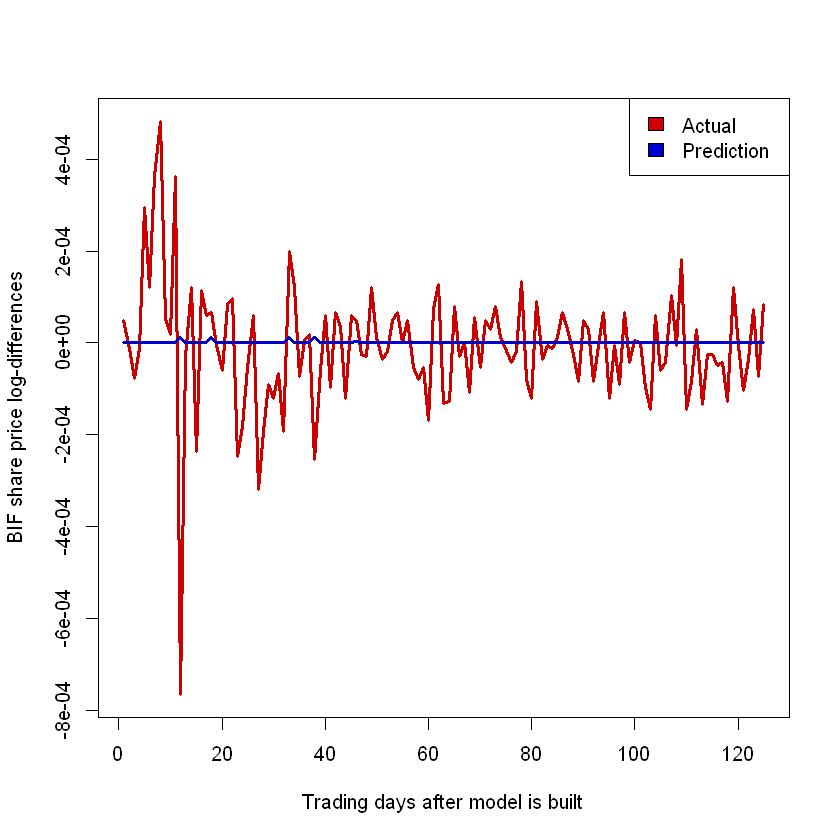

In [928]:
plot(as.ts(as.data.frame(test$y)),col = 'red3', t = 'l', xlab = 'Trading days after model is built', 
                                            ylab = 'BIF share price log-differences', lwd = 3)
lines(as.ts(as.data.frame(pred.rtn$predict)), col = 'blue3', lwd = 3)
legend(legend = c('Actual','Prediction'), fill = c('red3', 'blue3'), 'topright')

In [930]:
aml@leaderboard

                                             model_id mean_residual_deviance
1    StackedEnsemble_AllModels_AutoML_20200420_014417            0.001072587
2 StackedEnsemble_BestOfFamily_AutoML_20200420_014417            0.001282441
3                        GLM_1_AutoML_20200420_014417            0.001696753
4 DeepLearning_grid__1_AutoML_20200420_014417_model_2            0.003295714
5          GBM_grid__1_AutoML_20200420_014417_model_3            0.004100128
6          GBM_grid__1_AutoML_20200420_014417_model_4            0.004257438
        rmse         mse        mae      rmsle
1 0.03275038 0.001072587 0.02513993 0.01951107
2 0.03581118 0.001282441 0.02688427 0.02115526
3 0.04119166 0.001696753 0.03570174 0.02516261
4 0.05740831 0.003295714 0.04022496 0.03424728
5 0.06403224 0.004100128 0.05190670 0.03984753
6 0.06524904 0.004257438 0.05332356 0.04072716

[23 rows x 6 columns] 

In [932]:
for_aml.dif <- for_plot3[complete.cases(for_plot3),]
for_aml.dif <- as.data.frame(for_aml.dif)
rownames(for_aml.dif) <- NULL 
for_aml.dif <- as.ts(for_aml.dif)
for_aml.dif <- diff(for_aml.dif, lag = 1)
for_aml.dif <- as.data.frame(for_aml.dif)
for_aml.dif$Score[which(!is.finite(for_aml.dif$Score))] <- 0
for (i in 3:(nrow(x = for_aml.dif))) {
    x = 10
    f_list <- for_aml.dif[c(1:i),c(1:x)]
    myfeatures <- tsfeatures(f_list)
    myfeatures  <- as.data.frame(myfeatures)
    for (k in 1:nrow(myfeatures)){
        a <- myfeatures[k,]
        colnames(a) <- paste0(colnames(a), '.', colnames(for_aml.dif)[k])
        col1 <- x+1+(k-1)*(ncol(a))
        col2 <-  x+1+k*(ncol(a)) - 1
        for_aml.dif[i, c(col1:col2)] <- a
    }
}
for_aml.dif <- for_aml.dif[,colSums(is.na(for_aml.dif))<nrow(for_aml.dif)]
ncol(for_aml.dif)
for (i in 1:10){
    for (j in 1:160){
        for_aml.dif[,(160*i+j)] <- dplyr::lag(for_aml.dif[,j], n = i)
        colnames(for_aml.dif)[(160*i+j)] <- as.character(paste0(as.character(colnames(for_aml.dif)[(j)]), '.l', i))
    }
}
for_aml.dif$y <- dplyr::lead(for_aml.dif$BIF.CO.Close, n = 1)
y <- 'y'
for_aml.dif <- for_aml.dif[-c(1:20, nrow(for_aml.dif)),]
sum(is.na(for_aml.dif)) 

[1] 160

[1] 0

In [ ]:
train <- as.h2o(for_aml.dif[c(1:600),])
test <- as.h2o(for_aml.dif[c(601:725),])
oldw <- getOption("warn")
options(warn = -1)
aml_dif <- h2o.automl(y = y,
                  training_frame = train,
                  max_runtime_secs = 120,
                  leaderboard_frame = test,
                  seed = 1,
                  project_name = "new_n_t.dif")
options(warn = oldw)

In [805]:
final_pred <- NULL 
final_pred <- as.data.frame(final_pred)
n <- nrow(for_aml2)
dp <- 10 #количество дней, на которые будет строиться прогноз - 1
for (p in (n-dp):n) { 
    
    train <- as.h2o(for_aml2[c(1:(p-1)),]) # тренировочную выборку постоянно увеличиваем
    test <- as.h2o(for_aml2[c(p:n),]) # тестовую выборку постоянно уменьшаем
    oldw <- getOption("warn") # отключаем предупреждения об ошибке
    options(warn = -1)
    aml8 <- h2o.automl(y = y,
                  training_frame = train,
                # leaderboard_frame = test, # не заглядываем в будущее
                  max_runtime_secs = 120, # пока поставлю так, может потом поставлю побольше
                  seed = 1,
                  project_name = paste0('final_n_t_', p)) # чтобы не были одинаковые названия,  число - первый день теста
    pred9 <- h2o.predict(aml8, test) # делаю прогноз
    final_pred[(p-n+dp+1),1] <- as.numeric(pred9[1,1]) # из прогноза достаю только 1 значение
    final_pred[(p-n+dp+1),2] <- as.numeric(for_aml2$y[p]) # рядом с ним ставлю реальное значение на этот день 
}


  |======================================================================| 100%
  |======================================================================| 100%
  |                                                                      |   0%
01:31:43.286: AutoML: XGBoost is not available; skipping it.
01:36:04.425: New models will be added to existing leaderboard final_n_t_719@@y (leaderboard frame=null) with already 15 models.
01:36:04.426: AutoML: XGBoost is not available; skipping it.
01:38:07.207: StackedEnsemble_BestOfFamily_AutoML_20200421_013604 [StackedEnsemble best (built using top model from each algorithm type)] failed: water.exceptions.H2OIllegalArgumentException: Failed to find the xval predictions frame. . .  Looks like keep_cross_validation_predictions wasn't set when building the models, or the frame was deleted.
01:38:08.223: StackedEnsemble_AllModels_AutoML_20200421_013604 [StackedEnsemble all (built using all AutoML models)] failed: water.exceptions.H2OIllegalArgumentE

In [807]:
real_pred <- NULL
real_pred <- as.data.frame(real_pred)
real_pred[c(1:20),1] <- for_aml2$y[c((n-dp-20):(n-dp-1))]
real_pred[c(1:20),2] <- for_aml2$y[c((n-dp-20):(n-dp-1))]
real_pred[c(21:(21+dp)),1] <- final_pred[,1]
real_pred[c(21:(21+dp)),2] <- final_pred[,2]